<a href="https://colab.research.google.com/github/lorenzrossi/AMD-ComicsFaces/blob/main/AMD_Models_batch_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from os import listdir
import pandas as pd
# Basic packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle

# Image preprocessing
import pathlib
import PIL
import PIL.Image
import cv2

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical, load_img, img_to_array
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, callbacks, regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.losses import binary_crossentropy
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Cross Validation
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, zero_one_loss

tfk = tf.keras
tf.keras.backend.set_floatx("float64")


from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/ComicsFaces'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
X = pickle.load(open('/content/drive/MyDrive/ComicsFaces/Pickles/X.pickle','rb'))
y = pickle.load(open('/content/drive/MyDrive/ComicsFaces/Pickles/y.pickle','rb'))

pics_classes = ['comics','faces']

images_to_plot = 8

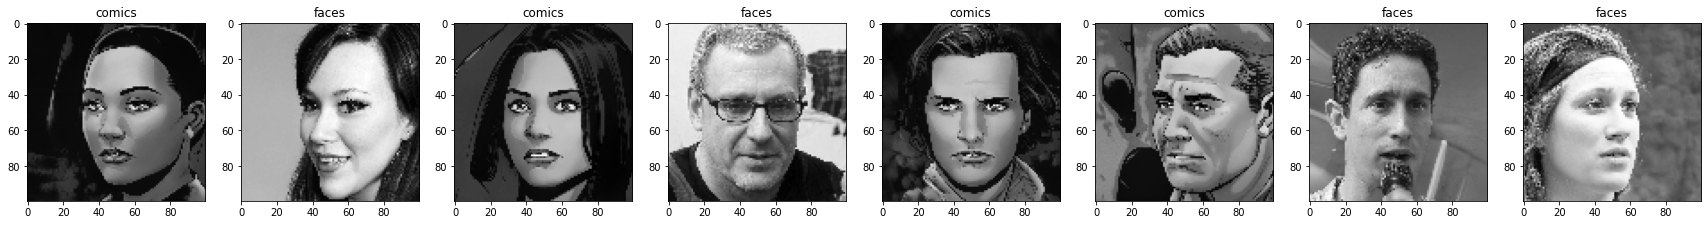

In [3]:
f, ax = plt.subplots(1, images_to_plot)
f.set_size_inches(30, 20)

gray_channel = 0

for i in range(images_to_plot):
  gray_image = X[i][:, :, gray_channel]
  ax[i].imshow(gray_image, cmap = "gray")
  numeric_label = y[i]
  ax[i].set_title(pics_classes[numeric_label])

In [4]:
number_of_classes = len(pics_classes)

In [5]:
x_size, img_dim = X.shape[0], X.shape[1]

# rescale in [0,1]
X = tf.cast(X, tf.float32) / 255.0

# one hot encoding
depth = 1
y = tf.reshape(tf.one_hot(y, depth), shape = [x_size, depth])

In [6]:
# Train test splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [7]:
# Hyperparameters
epoch = 20 # n of epochs
batch = 128 # batch size

# Defining the loss
loss = keras.losses.BinaryCrossentropy()

# Defining the optimizer(s)
op_1 = Adam()
op_2 = SGD(learning_rate=0.01, momentum=0.9, decay=0.01/50)
op_3 = RMSprop(learning_rate=1e-3)

In [8]:
# Defining plots
legend_size = 14

def performance_plot(history):
    plt.figure(figsize=(20,8))

    # Loss plots
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','test'], fontsize = legend_size)

    # Accuracy plots
    plt.subplot(1,2,2)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.ylabel('accuracy', size = 12)
    plt.xlabel('epoch', size = 12)
    plt.legend(['train','val'], fontsize = legend_size)

    plt.show()

# TRAINING MODEL 1

In [9]:
model1 = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size = (2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, use_bias=False, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation = 'sigmoid')
        ])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      288       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                        

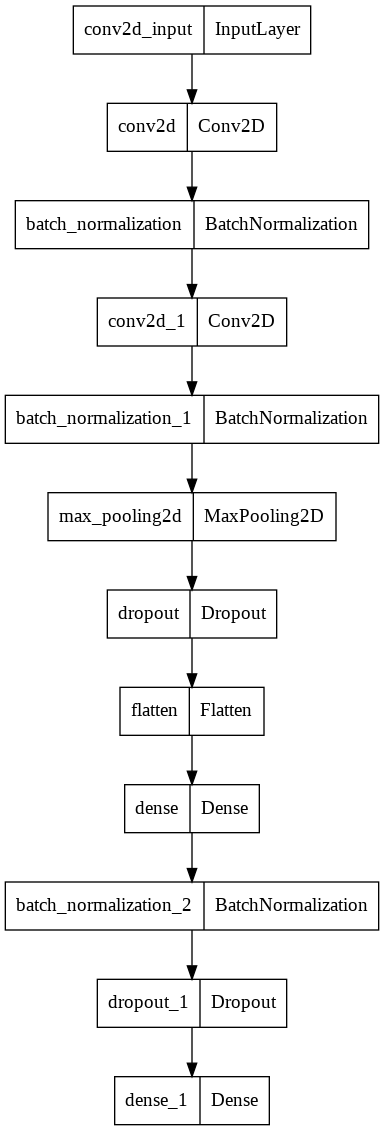

In [10]:
keras.utils.plot_model(model1, 'model.png')

Epoch 1/20
100/100 [==============================] - 11s 65ms/step - loss: 0.0437 - binary_accuracy: 0.9857 - val_loss: 1.2704 - val_binary_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 6s 62ms/step - loss: 0.0032 - binary_accuracy: 0.9993 - val_loss: 1.5999 - val_binary_accuracy: 0.4975
Epoch 3/20
100/100 [==============================] - 6s 62ms/step - loss: 0.0013 - binary_accuracy: 0.9998 - val_loss: 0.0980 - val_binary_accuracy: 0.9650
Epoch 4/20
100/100 [==============================] - 6s 62ms/step - loss: 8.2205e-04 - binary_accuracy: 0.9997 - val_loss: 0.2492 - val_binary_accuracy: 0.8862
Epoch 5/20
100/100 [==============================] - 6s 62ms/step - loss: 4.3200e-04 - binary_accuracy: 1.0000 - val_loss: 0.0312 - val_binary_accuracy: 0.9891
Epoch 6/20
100/100 [==============================] - 6s 62ms/step - loss: 3.5662e-04 - binary_accuracy: 1.0000 - val_loss: 0.0071 - val_binary_accuracy: 0.9978
Epoch 7/20
100/100 [=========================

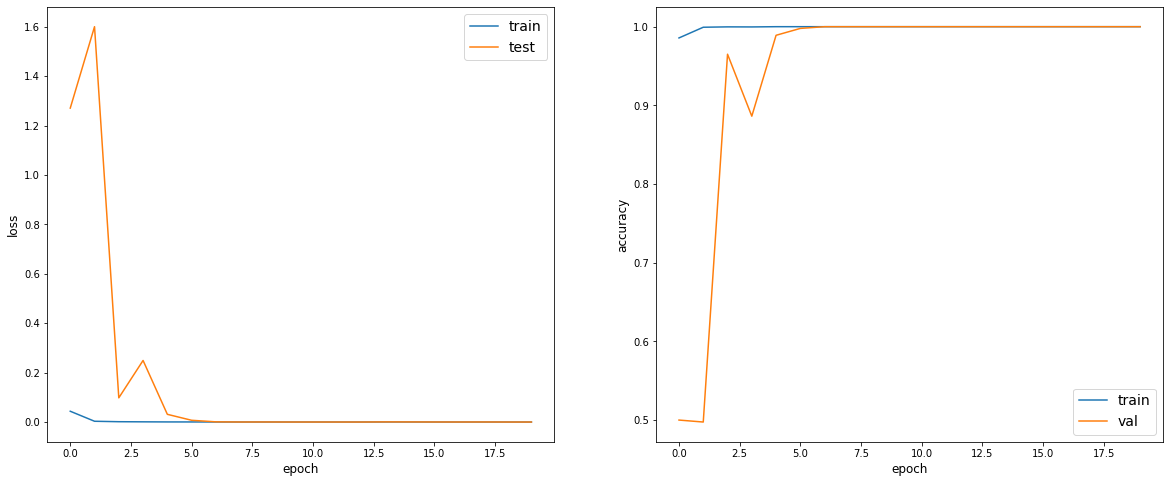

125/125 [==============================] - 1s 7ms/step - loss: 5.4477e-05 - binary_accuracy: 1.0000
test loss, test acc: [5.447663014957694e-05, 1.0]


In [11]:
# compiling the model
model1.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model1.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_1 = model1.evaluate(X_test, y_test)
print("test loss, test acc:", result_1)

# TRAINING MODEL 2

In [12]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_3 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_4 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                      

Epoch 1/20
100/100 [==============================] - 9s 79ms/step - loss: 0.0302 - binary_accuracy: 0.9880 - val_loss: 0.7414 - val_binary_accuracy: 0.6650
Epoch 2/20
100/100 [==============================] - 8s 76ms/step - loss: 0.0038 - binary_accuracy: 0.9991 - val_loss: 4.1411 - val_binary_accuracy: 0.4975
Epoch 3/20
100/100 [==============================] - 8s 76ms/step - loss: 0.0020 - binary_accuracy: 0.9993 - val_loss: 2.9340 - val_binary_accuracy: 0.5328
Epoch 4/20
100/100 [==============================] - 8s 76ms/step - loss: 0.0013 - binary_accuracy: 0.9998 - val_loss: 2.8601 - val_binary_accuracy: 0.7137
Epoch 5/20
100/100 [==============================] - 8s 76ms/step - loss: 5.5871e-04 - binary_accuracy: 1.0000 - val_loss: 0.1868 - val_binary_accuracy: 0.9703
Epoch 6/20
100/100 [==============================] - 8s 76ms/step - loss: 4.1265e-04 - binary_accuracy: 0.9999 - val_loss: 2.3972 - val_binary_accuracy: 0.8688
Epoch 7/20
100/100 [==============================

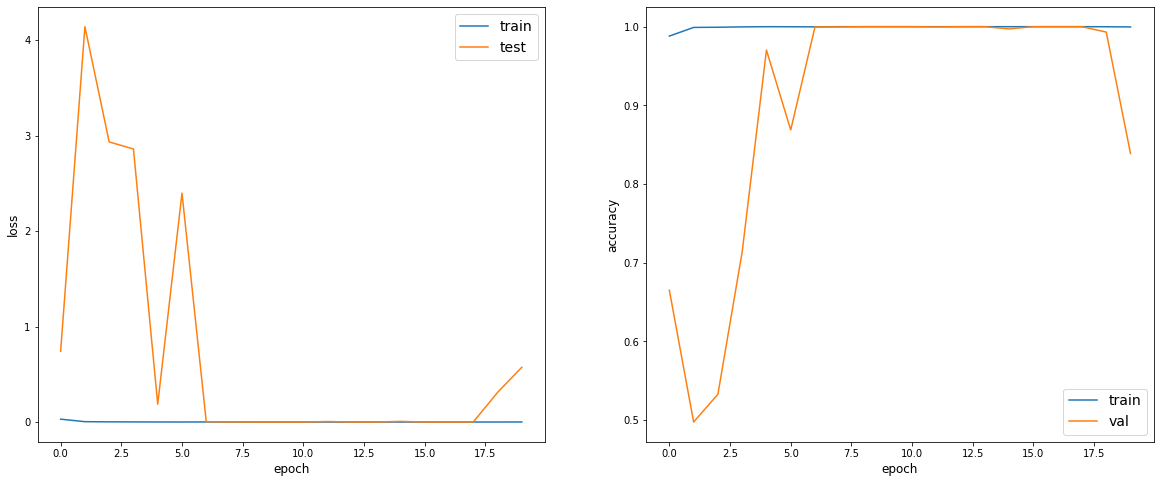

125/125 [==============================] - 1s 8ms/step - loss: 0.6558 - binary_accuracy: 0.8320
test loss, test acc: [0.6558429072092625, 0.832]


In [13]:
# compiling the model
model2.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model2.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_2 = model2.evaluate(X_test, y_test)
print("test loss, test acc:", result_2)

# TRAINING MODEL 3

In [14]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, input_shape = (100, 100, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), padding = "same", use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, use_bias=False, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      288       
                                                                 
 batch_normalization_7 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 32)      9216      
                                                                 
 batch_normalization_8 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                      

Epoch 1/20
100/100 [==============================] - 10s 88ms/step - loss: 0.0421 - binary_accuracy: 0.9863 - val_loss: 8.6672 - val_binary_accuracy: 0.5025
Epoch 2/20
100/100 [==============================] - 8s 85ms/step - loss: 0.0058 - binary_accuracy: 0.9984 - val_loss: 4.0882 - val_binary_accuracy: 0.5025
Epoch 3/20
100/100 [==============================] - 8s 85ms/step - loss: 0.0032 - binary_accuracy: 0.9993 - val_loss: 0.8731 - val_binary_accuracy: 0.5247
Epoch 4/20
100/100 [==============================] - 8s 85ms/step - loss: 0.0027 - binary_accuracy: 0.9993 - val_loss: 0.4693 - val_binary_accuracy: 0.7478
Epoch 5/20
100/100 [==============================] - 8s 85ms/step - loss: 0.0022 - binary_accuracy: 0.9993 - val_loss: 0.1098 - val_binary_accuracy: 0.9628
Epoch 6/20
100/100 [==============================] - 8s 85ms/step - loss: 0.0011 - binary_accuracy: 0.9998 - val_loss: 0.0180 - val_binary_accuracy: 0.9947
Epoch 7/20
100/100 [==============================] - 8s 

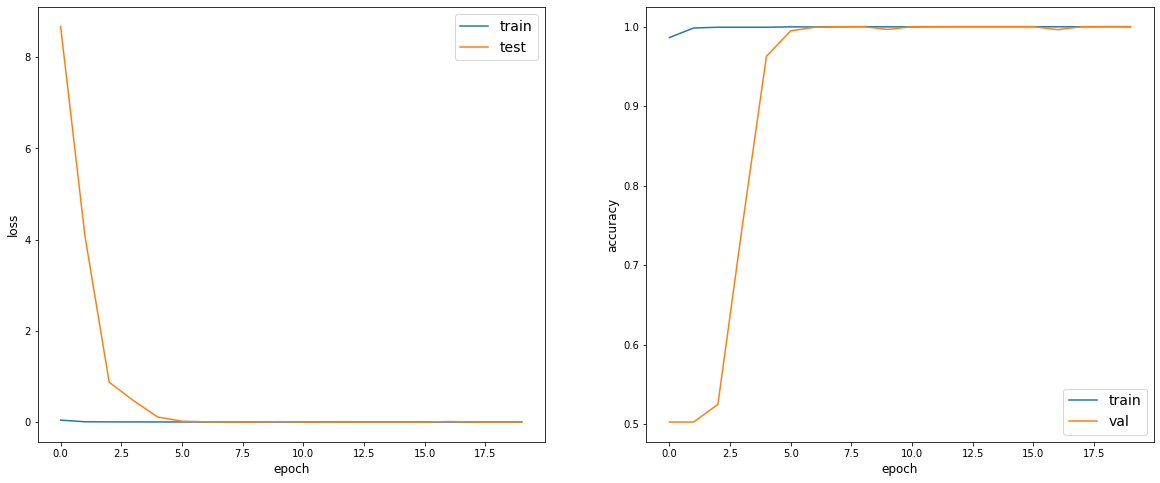

125/125 [==============================] - 1s 9ms/step - loss: 3.1866e-04 - binary_accuracy: 1.0000
test loss, test acc: [0.0003186626126400348, 1.0]


In [15]:
# compiling the model
model3.compile(optimizer = op_1, loss=loss, metrics=['binary_accuracy'])

history = model3.fit(X_train, y_train, epochs = epoch, batch_size = batch, verbose = 1, validation_split = 0.2)

performance_plot(history)

result_3 = model3.evaluate(X_test, y_test)
print("test loss, test acc:", result_3)